In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from tempfile import TemporaryFile

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle, class_weight
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v3 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-c', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-i', '--in_dir', type=str, help='directory containing 01_data_encoding intermediate tsv files')

#simulate command line input
cmdline_str='-c ' + " HepG2,K562 " + \
    ' -i ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_2overlap/ATAC/"

seq_names = ["ATAC", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
print("all files found!")

all files found!


In [3]:
def get_data(cell_types, in_dir, seq_names):

    first_cell = True
    for cell in cell_types:
        print(cell)

        pos = []
        neg = []
        first_seq = True
        for seq in seq_names:
            print("-"+seq)

            pos_name = in_dir+cell+"."+seq+".pos.tsv"
            pos_mat = np.loadtxt(pos_name, delimiter='\t')

            neg_name = in_dir+cell+"."+seq+".neg.tsv"
            neg_mat = np.loadtxt(neg_name, delimiter='\t')

            if first_seq:
                for i in pos_mat:
                    pos.append(np.array([i]))
                for i in neg_mat:
                    neg.append(np.array([i]))
                first_seq = False
            else:
                for i in range(len(pos)):
                    pos[i] = np.vstack((pos[i], pos_mat[i,]))
                for i in range(len(neg)):
                    neg[i] = np.vstack((neg[i], neg_mat[i,]))

        if first_cell == True:
            X_pos = np.array(pos)
            X_neg = np.array(neg)
            first_cell = False
        else:
            X_pos = np.vstack((X_pos, pos))
            X_neg = np.vstack((X_neg, neg))

    X = np.vstack((X_pos, X_neg))
    y = np.array([1 for i in range(X_pos.shape[0])] + [0 for i in range(X_neg.shape[0])]).reshape(-1,1)
    print(X.shape)
    print(y.shape)
    
    return X, y
  
# X, y = get_data(args.cell_types, args.in_dir, seq_names)
# with open(args.in_dir + "hg38_signals.pickle", 'wb') as f:
#     pickle.dump((X,y), f)

In [4]:
with open(args.in_dir + "hg38_signals.pickle", 'rb') as f:
    X, y = pickle.load(f)
window_size = int(X.shape[2] * 10)
X, y = shuffle(X, y, random_state=0)
x_train = np.expand_dims(X, axis=4)
y_train = y

#calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train.flatten())

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


In [5]:
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# construct the model
model = create_model(width=int(window_size/10))

adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
    metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])

#train the model
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    shuffle=True,
                    class_weight=class_weights,
                    callbacks=[es]) 

model.save_weights('./saved_models/ATAC_hg38.v3.h5')

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 142332 samples, validate on 15815 samples
Epoch 1/100
142332/142332 [==============================] - 133s 937us/step - loss: 0.1264 - acc: 0.9776 - auroc: 0.9520 - auprc: 0.8056 - f1_m: 0.8041 - recall_m: 0.8277 - precision_m: 0.8124 - val_loss: 0.0564 - val_acc: 0.9855 - val_auroc: 0.9927 - val_auprc: 0.9242 - val_f1_m: 0.8802 - val_recall_m: 0.8799 - val_precision_m: 0.9031
Epoch 2/100
142332/142332 [==============================] - 129s 909us/step - loss: 0.0463 - acc: 0.9877 - auroc: 0.9945 - auprc: 0.9384 - f1_m: 0.8842 - recall_m: 0.9141 - precision_m: 0.8753 - val_loss: 0.0394 - val_acc: 0.9895 - val_auroc: 0.9955 - val_auprc: 0.9467 - val_f1_m: 0.9107 - val_recall_m: 0.9297 - val_precision_m: 0.9074
Epoch 3/100
142332/142332 [==============================] - 129s 909us/step - loss: 0.0384 - acc: 0.9889 - auroc: 0.9961 - auprc: 0.9517 - f1_m: 0.8975 - recall_m: 0.9276 - precision_m: 0.8869 - val_loss: 0.0360 - val_acc: 0.9898 - val_auroc: 0.9964 - val_auprc: 0.9549 

In [6]:
# --- ENCODE mm10 validation #1 ---#
def rename_tissue(feature):
    feature.name = feature[9]
    return feature

val_file1 = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/ENCFF095OCG.bed"
val_region1 = pybedtools.BedTool(val_file1).each(pybedtools.featurefuncs.midpoint).each(rename_tissue)
val_region1 = val_region1.slop(b=window_size/2, genome="mm10")
val_region1 = val_region1.filter(pybedtools.featurefuncs.greater_than, window_size-1)
val_region1 = val_region1.sort()
val_region1.head()

chr1	13003151	13007152	negative	0	.	13003747	13006556	0,0,255	negative
 chr1	31101021	31105022	negative	0	.	31101599	31104444	0,0,255	negative
 chr1	38197302	38201303	negative	0	.	38196744	38201861	0,0,255	negative
 chr1	39946111	39950112	forebrain [7/9], cranial nerve [7/9], dorsal root ganglion [7/9]	1	.	39945533	39950689	255,0,0	forebrain [7/9], cranial nerve [7/9], dorsal root ganglion [7/9]
 chr1	68778680	68782681	negative	0	.	68779329	68782031	0,0,255	negative
 chr1	75287729	75291730	forebrain [5/12]	1	.	75288287	75291172	255,0,0	forebrain [5/12]
 chr1	75405463	75409464	negative	0	.	75405116	75409810	0,0,255	negative
 chr1	97538619	97542620	forebrain [3/4], midbrain [3/4], hindbrain [3/4], neural tube [3/4]	1	.	97538497	97542741	255,0,0	forebrain [3/4], midbrain [3/4], hindbrain [3/4], neural tube [3/4]
 chr1	127754934	127758935	negative	0	.	127754802	127759066	0,0,255	negative
 chr1	158264756	158268757	midbrain [3/4], hindbrain [3/4], neck [3/4]	1	.	158265467	158268046	255,0,0	m

In [7]:
# --- ENCODE mm10 validation #2 --- #
# val_file2 = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/ENCFF915YMM.bed"
# val_region2 = pybedtools.BedTool(val_file2).each(pybedtools.featurefuncs.midpoint).each(rename_tissue)
# val_region2 = val_region2.slop(b=window_size/2, genome="mm10")
# val_region2 = val_region2.filter(pybedtools.featurefuncs.greater_than, window_size-1)
# val_region2 = val_region2.sort()
# val_region2.head()

In [8]:
# --- VISTA mm9->mm10 validation ---#

val_file3_raw = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/VISTA_mm10_raw.bed"
val_file3_label = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/VISTA_mm9.txt"
val_file3 = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/VISTA_mm10.bed"

df1 = pd.read_csv(val_file3_raw, sep="\t",header=None)
df1_label = pd.read_csv(val_file3_label, sep="\t",header=None)
df1[3] = df1_label[3]
df1.to_csv(val_file3, sep="\t",header=None, index=False)

val_region3 = pybedtools.BedTool(val_file3)
val_region3 = val_region3.each(pybedtools.featurefuncs.midpoint)
val_region3 = val_region3.slop(b=window_size/2, genome="mm10")
val_region3 = val_region3.filter(pybedtools.featurefuncs.greater_than, window_size-1)
val_region3 = val_region3.sort()
val_region3.head()
# print("limb" in val_region3[3][3])

chr1	5020950	5024951	element 911 | negative 
 chr1	9647594	9651595	element 1545 | negative 
 chr1	11025292	11029293	element 659 | negative 
 chr1	12498493	12502494	element 1417 | positive  | limb[5/5] | tail[5/5]
 chr1	12508534	12512535	element 1415 | positive  | limb[9/9]
 chr1	12614067	12618068	element 663 | negative 
 chr1	13003151	13007152	element 1341 | positive  | hindbrain (rhombencephalon)[6/6] | midbrain (mesencephalon)[6/6] | forebrain[6/6] | limb[6/6] | other[3/6]
 chr1	19765625	19769626	element 1771 | negative 
 chr1	31101021	31105022	element 1356 | negative 
 chr1	33988988	33992989	element 664 | negative 
 

In [9]:
# --- merge validation regions from all three sources --- #
# validation_regions = val_region1.cat(val_region2, postmerge=False).cat(val_region3, postmerge=False)
validation_regions = val_region1.cat(val_region3, postmerge=False)
validation_regions.saveas("./mm10/mm10.validation_regions.bed")
# validation_regions.head()

<BedTool(./mm10/mm10.validation_regions.bed)>

In [10]:
# ---- separate positive and negative for each tissue from the files ---- #

def tissue_pos(feature, tissue):
    if tissue in feature.name:
        return True
    else:
        return False

def tissue_neg(feature, tissue):
    if tissue in feature.name:
        return False
    else:
        return True
    
samples = ["forebrain", "heart", "hindbrain", "limb", "midbrain", "neural tube"]
seq_names = ["ATAC-seq", "ChIP-seq.H3K27ac", "ChIP-seq.H3K4me3", "ChIP-seq.H3K9ac", "ChIP-seq.H3K4me1"]
sample_dir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/bigWig/"

In [11]:
# # ---- read in bigwig files ---- #
# def bigWigAverageOverBed(x, bigwig):
# #     print(x)
#     return bigwig.stats(x.chrom, x.start, x.stop, nBins=int(window_size/10))

# def get_signal(region, bigwig):
#     return [bigWigAverageOverBed(x, bigwig) for x in region]

# file_samples = ["forebrain", "heart", "hindbrain", "limb", "midbrain", "neural_tube"]

# peak_set = []
# track_set = []
# for sam in file_samples:
#     all_seq_peak = []
#     all_seq_track = []
#     for seq in seq_names:
#         all_seq_peak.append(sample_dir + sam + "."+ seq + ".narrowPeak")
#         all_seq_track.append(sample_dir + sam + "."+ seq + ".bigWig")
#     peak_set.append(all_seq_peak)
#     track_set.append(all_seq_track)


# # print(track_set)

# X = []
# Y = []
# for i in range(len(samples)):
    
#     #organized per track for all samples
#     signal_X = []
#     signal_Y = []
#     for track in track_set[i]:
#     #   print(track)        
#         pos_bed = pybedtools.BedTool("./mm10/mm10.validation_regions.bed").filter(tissue_pos, samples[i])
#         neg_bed = pybedtools.BedTool("./mm10/mm10.validation_regions.bed").filter(tissue_neg, samples[i])
#         pos = get_signal(pos_bed, pyBigWig.open(track))
#         neg = get_signal(neg_bed, pyBigWig.open(track))

#         x_combined = pos + neg
#         signal_X.append(x_combined)
        
#     print(samples[i], len(pos), len(neg))
        
#     #reorganize per sample for all tracks
#     signal_reform_X = []
#     for j in range(len(x_combined)):
#         per_track_X = []
#         for t in range(len(track_set[i])):
#             per_track_X.append(np.array(signal_X[t][j]))
#         signal_reform_X.append(np.array(per_track_X))
#     signal_reform_X = np.expand_dims(np.array(signal_reform_X), axis=4)
#     X.append(signal_reform_X)
    
#     y_combined = [1 for i in pos] + [0 for i in neg]
#     Y.append(np.array(y_combined))
    
# with open(args.in_dir + "mm10_signals.pickle", 'wb') as f:
#     pickle.dump((X,Y), f)

In [12]:
with open("./mm10/mm10_signals.pickle", 'rb') as f:
    X,Y = pickle.load(f)

In [13]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    y_pred = model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

forebrain validation accuracy is: 0.6698194325021496
heart validation accuracy is: 0.705932932072227
hindbrain validation accuracy is: 0.6913155631986242
limb validation accuracy is: 0.6835769561478934
midbrain validation accuracy is: 0.6577815993121238
neural tube validation accuracy is: 0.709372312983663


In [14]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    
    #fine-tuning
    X_ft = X.copy()
    X_ft.pop(i)
    X_ft = np.array(X_ft)
    X_ft = X_ft.reshape((-1, X_ft.shape[2], X_ft.shape[3], X_ft.shape[4]))
    
    Y_ft = Y.copy()
    Y_ft.pop(i)
    Y_ft = np.array(Y_ft)
    Y_ft = Y_ft.reshape((-1, 1))
    
    X_ft, Y_ft = shuffle(X_ft, Y_ft, random_state=0)
    
    class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_ft),
                                                  Y_ft.flatten())
    
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    ft_model = create_model(width=int(window_size/10))
    ft_model.load_weights('./saved_models/ATAC_hg38.v3.h5')
    ft_model.compile(loss='binary_crossentropy', 
                     optimizer=Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5), 
                     metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
    
    #train the model
    history = ft_model.fit(X_ft, Y_ft,
                        batch_size=4,
                        epochs=100,
                        validation_split=0.1,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[es])
    
    

    y_pred = ft_model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 26s 5ms/step - loss: 0.6979 - acc: 0.7739 - auroc: 0.6612 - auprc: 0.2414 - f1_m: 0.1216 - recall_m: 0.1456 - precision_m: 0.1167 - val_loss: 0.5865 - val_acc: 0.8677 - val_auroc: 0.6556 - val_auprc: 0.2262 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4783 - acc: 0.8616 - auroc: 0.6502 - auprc: 0.2177 - f1_m: 7.6438e-04 - recall_m: 7.6438e-04 - precision_m: 7.6438e-04 - val_loss: 0.5082 - val_acc: 0.8729 - val_auroc: 0.6466 - val_auprc: 0.2119 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4412 - acc: 0.8624 - auroc: 0.6463 - auprc: 0.2092 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4736 - val_acc: 0.8729 - val_auroc: 0.64

5233/5233 [==============================] - 24s 5ms/step - loss: 0.3875 - acc: 0.8622 - auroc: 0.6513 - auprc: 0.2217 - f1_m: 0.0034 - recall_m: 0.0033 - precision_m: 0.0038 - val_loss: 0.3966 - val_acc: 0.8729 - val_auroc: 0.6516 - val_auprc: 0.2220 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 25/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3888 - acc: 0.8628 - auroc: 0.6520 - auprc: 0.2226 - f1_m: 0.0056 - recall_m: 0.0051 - precision_m: 0.0069 - val_loss: 0.3960 - val_acc: 0.8729 - val_auroc: 0.6523 - val_auprc: 0.2231 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 26/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3884 - acc: 0.8616 - auroc: 0.6525 - auprc: 0.2235 - f1_m: 0.0055 - recall_m: 0.0048 - precision_m: 0.0069 - val_loss: 0.3956 - val_acc: 0.8729 - val_auroc: 0.6528 - val_auprc: 0.2239 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_pr

Epoch 48/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3841 - acc: 0.8622 - auroc: 0.6622 - auprc: 0.2371 - f1_m: 0.0069 - recall_m: 0.0065 - precision_m: 0.0076 - val_loss: 0.3898 - val_acc: 0.8729 - val_auroc: 0.6624 - val_auprc: 0.2372 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 49/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3844 - acc: 0.8624 - auroc: 0.6625 - auprc: 0.2374 - f1_m: 0.0068 - recall_m: 0.0060 - precision_m: 0.0084 - val_loss: 0.3897 - val_acc: 0.8729 - val_auroc: 0.6627 - val_auprc: 0.2376 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 50/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3823 - acc: 0.8632 - auroc: 0.6628 - auprc: 0.2376 - f1_m: 0.0056 - recall_m: 0.0050 - precision_m: 0.0069 - val_loss: 0.3895 - val_acc: 0.8729 - val_auroc: 0.6630 - val_auprc: 0.2380 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000

Epoch 72/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3814 - acc: 0.8616 - auroc: 0.6685 - auprc: 0.2449 - f1_m: 0.0079 - recall_m: 0.0076 - precision_m: 0.0084 - val_loss: 0.3871 - val_acc: 0.8711 - val_auroc: 0.6686 - val_auprc: 0.2450 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 73/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3807 - acc: 0.8626 - auroc: 0.6687 - auprc: 0.2452 - f1_m: 0.0087 - recall_m: 0.0080 - precision_m: 0.0099 - val_loss: 0.3870 - val_acc: 0.8711 - val_auroc: 0.6688 - val_auprc: 0.2453 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 74/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3812 - acc: 0.8626 - auroc: 0.6688 - auprc: 0.2454 - f1_m: 0.0087 - recall_m: 0.0082 - precision_m: 0.0099 - val_loss: 0.3870 - val_acc: 0.8711 - val_auroc: 0.6690 - val_auprc: 0.2455 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000

Epoch 96/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3800 - acc: 0.8637 - auroc: 0.6725 - auprc: 0.2505 - f1_m: 0.0112 - recall_m: 0.0103 - precision_m: 0.0130 - val_loss: 0.3855 - val_acc: 0.8694 - val_auroc: 0.6726 - val_auprc: 0.2506 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 97/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3789 - acc: 0.8624 - auroc: 0.6726 - auprc: 0.2507 - f1_m: 0.0088 - recall_m: 0.0087 - precision_m: 0.0096 - val_loss: 0.3854 - val_acc: 0.8694 - val_auroc: 0.6727 - val_auprc: 0.2508 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 98/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3782 - acc: 0.8618 - auroc: 0.6728 - auprc: 0.2509 - f1_m: 0.0064 - recall_m: 0.0057 - precision_m: 0.0076 - val_loss: 0.3854 - val_acc: 0.8694 - val_auroc: 0.6729 - val_auprc: 0.2510 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000

5233/5233 [==============================] - 24s 5ms/step - loss: 0.3956 - acc: 0.8582 - auroc: 0.6433 - auprc: 0.2184 - f1_m: 0.0057 - recall_m: 0.0052 - precision_m: 0.0069 - val_loss: 0.3926 - val_acc: 0.8694 - val_auroc: 0.6436 - val_auprc: 0.2190 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 20/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3948 - acc: 0.8594 - auroc: 0.6441 - auprc: 0.2198 - f1_m: 0.0094 - recall_m: 0.0092 - precision_m: 0.0099 - val_loss: 0.3917 - val_acc: 0.8694 - val_auroc: 0.6446 - val_auprc: 0.2205 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 21/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3964 - acc: 0.8597 - auroc: 0.6451 - auprc: 0.2210 - f1_m: 0.0099 - recall_m: 0.0096 - precision_m: 0.0107 - val_loss: 0.3916 - val_acc: 0.8694 - val_auroc: 0.6453 - val_auprc: 0.2216 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_pr

5233/5233 [==============================] - 24s 5ms/step - loss: 0.3865 - acc: 0.8590 - auroc: 0.6593 - auprc: 0.2409 - f1_m: 0.0124 - recall_m: 0.0113 - precision_m: 0.0149 - val_loss: 0.3864 - val_acc: 0.8694 - val_auroc: 0.6594 - val_auprc: 0.2412 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 44/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3877 - acc: 0.8588 - auroc: 0.6596 - auprc: 0.2415 - f1_m: 0.0161 - recall_m: 0.0153 - precision_m: 0.0176 - val_loss: 0.3863 - val_acc: 0.8694 - val_auroc: 0.6598 - val_auprc: 0.2418 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
heart validation accuracy is: 0.8486672398968186
Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 26s 5ms/step - loss: 0.6988 - acc: 0.7732 - auroc: 0.6594 - auprc: 0.2253 - f1_m: 0.1052 - recall_m: 0.1208 - precision_m: 0.1048 - val_loss: 0.5653 - val_acc: 0.8608 - val_auroc: 0.6528 - val_a

Epoch 23/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4013 - acc: 0.8555 - auroc: 0.6543 - auprc: 0.2310 - f1_m: 0.0069 - recall_m: 0.0065 - precision_m: 0.0076 - val_loss: 0.3914 - val_acc: 0.8643 - val_auroc: 0.6544 - val_auprc: 0.2314 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 24/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3990 - acc: 0.8561 - auroc: 0.6548 - auprc: 0.2321 - f1_m: 0.0074 - recall_m: 0.0069 - precision_m: 0.0084 - val_loss: 0.3907 - val_acc: 0.8643 - val_auroc: 0.6552 - val_auprc: 0.2326 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 25/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3968 - acc: 0.8544 - auroc: 0.6557 - auprc: 0.2332 - f1_m: 0.0073 - recall_m: 0.0068 - precision_m: 0.0084 - val_loss: 0.3904 - val_acc: 0.8643 - val_auroc: 0.6561 - val_auprc: 0.2337 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

Epoch 48/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3911 - acc: 0.8571 - auroc: 0.6684 - auprc: 0.2500 - f1_m: 0.0144 - recall_m: 0.0136 - precision_m: 0.0161 - val_loss: 0.3859 - val_acc: 0.8660 - val_auroc: 0.6687 - val_auprc: 0.2504 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 49/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3917 - acc: 0.8557 - auroc: 0.6689 - auprc: 0.2506 - f1_m: 0.0125 - recall_m: 0.0122 - precision_m: 0.0134 - val_loss: 0.3858 - val_acc: 0.8660 - val_auroc: 0.6691 - val_auprc: 0.2508 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 50/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3937 - acc: 0.8571 - auroc: 0.6692 - auprc: 0.2511 - f1_m: 0.0169 - recall_m: 0.0163 - precision_m: 0.0183 - val_loss: 0.3857 - val_acc: 0.8660 - val_auroc: 0.6694 - val_auprc: 0.2512 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 73/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3891 - acc: 0.8563 - auroc: 0.6749 - auprc: 0.2584 - f1_m: 0.0162 - recall_m: 0.0155 - precision_m: 0.0180 - val_loss: 0.3840 - val_acc: 0.8643 - val_auroc: 0.6750 - val_auprc: 0.2585 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 74/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3883 - acc: 0.8546 - auroc: 0.6751 - auprc: 0.2586 - f1_m: 0.0129 - recall_m: 0.0121 - precision_m: 0.0145 - val_loss: 0.3839 - val_acc: 0.8643 - val_auroc: 0.6753 - val_auprc: 0.2588 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 75/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3889 - acc: 0.8559 - auroc: 0.6755 - auprc: 0.2590 - f1_m: 0.0150 - recall_m: 0.0141 - precision_m: 0.0168 - val_loss: 0.3839 - val_acc: 0.8643 - val_auroc: 0.6755 - val_auprc: 0.2591 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

5233/5233 [==============================] - 24s 5ms/step - loss: 0.4468 - acc: 0.8588 - auroc: 0.6534 - auprc: 0.2132 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4256 - val_acc: 0.8729 - val_auroc: 0.6502 - val_auprc: 0.2114 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 4/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4314 - acc: 0.8590 - auroc: 0.6476 - auprc: 0.2098 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4114 - val_acc: 0.8729 - val_auroc: 0.6450 - val_auprc: 0.2081 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 5/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4224 - acc: 0.8594 - auroc: 0.6437 - auprc: 0.2066 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4031 - val_acc: 0.8729 - val_auroc: 0.6425 - val_auprc: 0.2068 - val_f1_m: 0.0000e+00 -

5233/5233 [==============================] - 24s 5ms/step - loss: 0.3910 - acc: 0.8599 - auroc: 0.6603 - auprc: 0.2349 - f1_m: 0.0076 - recall_m: 0.0069 - precision_m: 0.0092 - val_loss: 0.3668 - val_acc: 0.8694 - val_auroc: 0.6608 - val_auprc: 0.2355 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 28/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3891 - acc: 0.8590 - auroc: 0.6614 - auprc: 0.2363 - f1_m: 0.0117 - recall_m: 0.0107 - precision_m: 0.0138 - val_loss: 0.3664 - val_acc: 0.8694 - val_auroc: 0.6616 - val_auprc: 0.2366 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 29/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3897 - acc: 0.8595 - auroc: 0.6619 - auprc: 0.2370 - f1_m: 0.0115 - recall_m: 0.0107 - precision_m: 0.0130 - val_loss: 0.3662 - val_acc: 0.8694 - val_auroc: 0.6623 - val_auprc: 0.2374 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 30/100
5

Epoch 52/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3849 - acc: 0.8601 - auroc: 0.6726 - auprc: 0.2514 - f1_m: 0.0131 - recall_m: 0.0121 - precision_m: 0.0153 - val_loss: 0.3631 - val_acc: 0.8711 - val_auroc: 0.6728 - val_auprc: 0.2516 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 53/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3855 - acc: 0.8611 - auroc: 0.6730 - auprc: 0.2518 - f1_m: 0.0132 - recall_m: 0.0123 - precision_m: 0.0153 - val_loss: 0.3630 - val_acc: 0.8711 - val_auroc: 0.6732 - val_auprc: 0.2521 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 54/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3872 - acc: 0.8605 - auroc: 0.6733 - auprc: 0.2524 - f1_m: 0.0162 - recall_m: 0.0152 - precision_m: 0.0183 - val_loss: 0.3629 - val_acc: 0.8711 - val_auroc: 0.6734 - val_auprc: 0.2525 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 77/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3849 - acc: 0.8605 - auroc: 0.6793 - auprc: 0.2608 - f1_m: 0.0166 - recall_m: 0.0149 - precision_m: 0.0199 - val_loss: 0.3614 - val_acc: 0.8694 - val_auroc: 0.6793 - val_auprc: 0.2609 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 78/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3824 - acc: 0.8607 - auroc: 0.6795 - auprc: 0.2611 - f1_m: 0.0173 - recall_m: 0.0168 - precision_m: 0.0183 - val_loss: 0.3614 - val_acc: 0.8694 - val_auroc: 0.6795 - val_auprc: 0.2612 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 79/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3842 - acc: 0.8597 - auroc: 0.6797 - auprc: 0.2614 - f1_m: 0.0138 - recall_m: 0.0126 - precision_m: 0.0161 - val_loss: 0.3614 - val_acc: 0.8694 - val_auroc: 0.6797 - val_auprc: 0.2615 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

5233/5233 [==============================] - 26s 5ms/step - loss: 0.7030 - acc: 0.7751 - auroc: 0.6735 - auprc: 0.2668 - f1_m: 0.1233 - recall_m: 0.1413 - precision_m: 0.1238 - val_loss: 0.4868 - val_acc: 0.8711 - val_auroc: 0.6662 - val_auprc: 0.2383 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4857 - acc: 0.8584 - auroc: 0.6660 - auprc: 0.2321 - f1_m: 0.0038 - recall_m: 0.0031 - precision_m: 0.0054 - val_loss: 0.4314 - val_acc: 0.8729 - val_auroc: 0.6597 - val_auprc: 0.2245 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4456 - acc: 0.8588 - auroc: 0.6564 - auprc: 0.2203 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4124 - val_acc: 0.8729 - val_auroc: 0.6540 - val_auprc: 0.2168 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+0

Epoch 25/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3909 - acc: 0.8584 - auroc: 0.6676 - auprc: 0.2340 - f1_m: 0.0056 - recall_m: 0.0054 - precision_m: 0.0061 - val_loss: 0.3657 - val_acc: 0.8711 - val_auroc: 0.6679 - val_auprc: 0.2345 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 26/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3908 - acc: 0.8599 - auroc: 0.6684 - auprc: 0.2352 - f1_m: 0.0078 - recall_m: 0.0071 - precision_m: 0.0092 - val_loss: 0.3651 - val_acc: 0.8711 - val_auroc: 0.6687 - val_auprc: 0.2355 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 27/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3897 - acc: 0.8582 - auroc: 0.6690 - auprc: 0.2359 - f1_m: 0.0036 - recall_m: 0.0034 - precision_m: 0.0038 - val_loss: 0.3649 - val_acc: 0.8711 - val_auroc: 0.6694 - val_auprc: 0.2364 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

Epoch 50/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3872 - acc: 0.8595 - auroc: 0.6790 - auprc: 0.2510 - f1_m: 0.0089 - recall_m: 0.0078 - precision_m: 0.0115 - val_loss: 0.3614 - val_acc: 0.8711 - val_auroc: 0.6791 - val_auprc: 0.2511 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 51/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3856 - acc: 0.8586 - auroc: 0.6794 - auprc: 0.2515 - f1_m: 0.0065 - recall_m: 0.0064 - precision_m: 0.0069 - val_loss: 0.3612 - val_acc: 0.8711 - val_auroc: 0.6795 - val_auprc: 0.2516 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 52/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3890 - acc: 0.8578 - auroc: 0.6796 - auprc: 0.2517 - f1_m: 0.0051 - recall_m: 0.0050 - precision_m: 0.0054 - val_loss: 0.3612 - val_acc: 0.8711 - val_auroc: 0.6797 - val_auprc: 0.2518 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

Epoch 75/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3834 - acc: 0.8595 - auroc: 0.6848 - auprc: 0.2593 - f1_m: 0.0110 - recall_m: 0.0103 - precision_m: 0.0122 - val_loss: 0.3596 - val_acc: 0.8711 - val_auroc: 0.6848 - val_auprc: 0.2594 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 76/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3866 - acc: 0.8601 - auroc: 0.6849 - auprc: 0.2595 - f1_m: 0.0130 - recall_m: 0.0127 - precision_m: 0.0149 - val_loss: 0.3596 - val_acc: 0.8711 - val_auroc: 0.6850 - val_auprc: 0.2596 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 77/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3855 - acc: 0.8592 - auroc: 0.6851 - auprc: 0.2598 - f1_m: 0.0149 - recall_m: 0.0140 - precision_m: 0.0168 - val_loss: 0.3595 - val_acc: 0.8711 - val_auroc: 0.6851 - val_auprc: 0.2599 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

Epoch 100/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.3833 - acc: 0.8599 - auroc: 0.6887 - auprc: 0.2645 - f1_m: 0.0164 - recall_m: 0.0155 - precision_m: 0.0183 - val_loss: 0.3585 - val_acc: 0.8694 - val_auroc: 0.6889 - val_auprc: 0.2647 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
midbrain validation accuracy is: 0.8495270851246776
Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 27s 5ms/step - loss: 0.7507 - acc: 0.7634 - auroc: 0.6571 - auprc: 0.2439 - f1_m: 0.1327 - recall_m: 0.1526 - precision_m: 0.1317 - val_loss: 0.4376 - val_acc: 0.8625 - val_auroc: 0.6538 - val_auprc: 0.2363 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 2/100
5233/5233 [==============================] - 25s 5ms/step - loss: 0.5244 - acc: 0.8454 - auroc: 0.6491 - auprc: 0.2306 - f1_m: 0.0038 - recall_m: 0.0038 - precision_m: 0.0038 - val_loss: 0.3974 - val_acc: 0.8677 - val_auroc

Epoch 24/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4167 - acc: 0.8454 - auroc: 0.6511 - auprc: 0.2411 - f1_m: 0.0101 - recall_m: 0.0094 - precision_m: 0.0115 - val_loss: 0.3607 - val_acc: 0.8660 - val_auroc: 0.6515 - val_auprc: 0.2416 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 25/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4155 - acc: 0.8450 - auroc: 0.6521 - auprc: 0.2423 - f1_m: 0.0070 - recall_m: 0.0064 - precision_m: 0.0084 - val_loss: 0.3606 - val_acc: 0.8660 - val_auroc: 0.6524 - val_auprc: 0.2429 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 26/100
5233/5233 [==============================] - 24s 5ms/step - loss: 0.4167 - acc: 0.8467 - auroc: 0.6529 - auprc: 0.2435 - f1_m: 0.0117 - recall_m: 0.0111 - precision_m: 0.0130 - val_loss: 0.3603 - val_acc: 0.8660 - val_auroc: 0.6532 - val_auprc: 0.2439 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


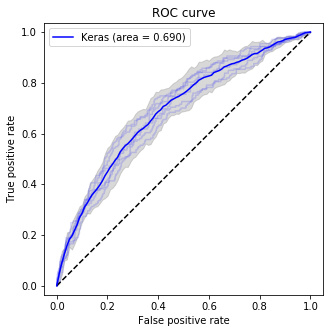

In [15]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(Y)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(Y[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


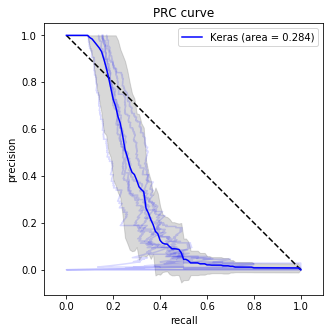

In [16]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(Y)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(Y[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(Y[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [17]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auROC: " + str(auroc_list[i]))

validated tissue forebrain auROC: 0.7109583598219962
validated tissue heart auROC: 0.715884904569115
validated tissue hindbrain auROC: 0.6996080839801951
validated tissue limb auROC: 0.6594052323204797
validated tissue midbrain auROC: 0.6591203401290382
validated tissue neural tube auROC: 0.6949492154727691


In [18]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auPRC: " + str(auprc_list[i]))

validated tissue forebrain auPRC: 0.33534124062672954
validated tissue heart auPRC: 0.2877085193934255
validated tissue hindbrain auPRC: 0.29506955385073774
validated tissue limb auPRC: 0.267154953269853
validated tissue midbrain auPRC: 0.29191884685501956
validated tissue neural tube auPRC: 0.22829781246276898
